| Kolom                    | Interpretasi                                  |
| ------------------------ | --------------------------------------------- |
| Age                      | Usia                                          |
| Attrition                | Tidak bekerja lagi                            |
| BusinessTravel           | Frekuensi bepergian (travelling)              |
| DailyRate                | Upah harian                                   |
| Department               | Departmen pada pekerjaan                      |
| DistanceFromHome         | Jarak dari rumah ke tempat kerja (KM)         |
| Education                |  1 'Below College' 2 'College' 3 'Bachelor' 4 'Master' 5 'Doctor' |
| EducationField           | Bidang pendidikan                             |
| EmployeeCount            |                                               |
| EmployeeNumber           |                                               |
| EnvironmentSatisfaction  | Kepuasan terhadap lingkungan kerja => 1 'Low' 2 'Medium' 3 'High' 4 'Very High'            |
| Gender                   | Jenis kelamin                                 |
| HourlyRate               | Upah perjam                                   |
| JobInvolvement           | Tingkat keterlibatan kerja => 1 'Low' 2 'Medium' 3 'High' 4 'Very High'                   |
| JobLevel                 | Level kesulitan pekerjaan                     |
| JobRole                  | Posisi Pekerjaan                              |
| JobSatisfaction          | Kepuasan terhadap pekerjaan => 1 'Low' 2 'Medium' 3 'High' 4 'Very High'                  |
| MaritalStatus            | Status Perkawinan                             |
| MonthlyIncome            | Income Bulanan                                |
| MonthlyRate              | Upah Bulanan                                  |
| NumCompaniesWorked       | Banyaknya perusahaan tempat bekerja           |
| Over18                   | Apakah usianya > 18?                          |
| OverTime                 | Apakah jam kerja overtime?                    |
| PercentSalaryHike        | Persentase kenaikan gaji                      |
| PerformanceRating        | Rating performa kerja  => 1 'Low' 2 'Good' 3 'Excellent' 4 'Outstanding'                       |
| RelationshipSatisfaction | Kepuasan terhadap relasi di tempat kerja => 1 'Low' 2 'Medium' 3 'High' 4 'Very High'      |
| StandardHours            | Standard jam kerja                            |
| StockOptionLevel         |                                               |
| TotalWorkingYears        | Lama bekerja (Tahun)                          |
| TrainingTimesLastYear    | Jumlah training tahun kemarin                 |
| WorkLifeBalance          | Keseimbangan kerja => 1 'Bad' 2 'Good' 3 'Better' 4 'Best'                           |
| YearsAtCompany           | Lama bekerja pada perusahaan                  |
| YearsInCurrentRole       | Lama bekerja pada posisi ini                  |
| YearsSinceLastPromotion  | Lama berkerja sejak kenaikan jabatan terakhir |
| YearsWithCurrManager     | Lama bekerja dengan manager saat ini          |

# __SUPERVISED LEARNING__

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

rcParams['figure.figsize'] = (10,7)
rcParams['lines.linewidth'] = 2.5
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

sns.set_theme(style='darkgrid')
sns.set(font_scale=1.2, palette='Set1')

import warnings
warnings.filterwarnings('ignore')

## __MODELLING__

### __SPLIT DATA__

Kami akan melakukan split data dengan menggunakan train_test_split dengan perbandingan 70:30

In [2]:
df = pd.read_csv('../Stage 2/Preprocessed.csv')

#pisahkan target dan fitur
x = df.drop('Attrition', axis=1)
y = df['Attrition']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, stratify=y, random_state=7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1029, 20), (441, 20), (1029,), (441,))

### __HANDLE IMBALANCE__

In [3]:
print('Before\n',y_train.value_counts())

from imblearn import over_sampling
X_train, y_train = over_sampling.SMOTE().fit_resample(X_train, y_train)

print('\nAfter\n',y_train.value_counts())

Before
 0    863
1    166
Name: Attrition, dtype: int64

After
 0    863
1    863
Name: Attrition, dtype: int64


 - Kasus False Negative

 Karyawan yang diprediksi akan melakukan resign tapi data aktualnya tidak resign, hal ini jika dilakukan "perlakuan khusus" akan membuat cost untuk hal ini menjadi membesar tanpa hasil apapun karena memang karyawan tidak berencana utk resign

 - Kasus False Positive

 Karyawan yang diprediksi tidak akan resign, tapi data aktualnya resign, hal ini jika dilakukan "perlakuan khusus" akan membuat company kehilangan karyawan yang potensial, sehingga membuat company mengalami kerugian karena juga harus melakukan rekrutmen yang membutuhkan biaya

Metriks yang kita gunakan dalam case ini adalah roc_auc, karena kita sama sama mementingkan FN dan FP, selain itu dataset ini juga termasuk imbalance 

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        y_pred_proba = model.predict_proba(X_test)
        y_pred_proba_train = model.predict_proba(X_train)

        print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
        print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
        print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
        print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

        print("\nroc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
        print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))

        score = cross_validate(model, x, y, cv=5, scoring='roc_auc', return_train_score=True)
        print('\nroc_auc (crossval train): '+ str(round(score['train_score'].mean(),2)))
        print('roc_auc (crossval test): '+ str(round(score['test_score'].mean(),2)))

def show_feature_importance(model):
        feat_importances = pd.Series(model.feature_importances_, index=x.columns)
        ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
        ax.invert_yaxis()

        plt.xlabel('score')
        plt.ylabel('feature')
        plt.title('feature importance score')

model,accuracy,precision,recall,f1,auc,status=[],[],[],[],[],[],[]

### __LOGISTIC REGRESSION__

Kami menggunakan algoritma logistik regression karena algoritma ini termasuk yang simple dan komputasinya cepat, sehingga bisa dijadikan sebagai base model untuk melihat seberapa bagus performa model

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=110)
lr.fit(X_train, y_train)

eval_classification(lr)

Accuracy (Test Set): 0.75
Precision (Test Set): 0.36
Recall (Test Set): 0.73
F1-Score (Test Set): 0.48

roc_auc (train-proba): 0.87
roc_auc (test-proba): 0.81

roc_auc (crossval train): 0.82
roc_auc (crossval test): 0.81


#### __TUNING HYPERPARAMETER__

In [6]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.0001, 1, 100)]

hyperparam = {
        'penalty':penalty,
        'C':C
}

lr = LogisticRegression(max_iter=150)
lr.fit(X_train, y_train)

rs = RandomizedSearchCV(lr, hyperparam, cv=5, scoring='roc_auc', random_state=7, n_iter=50)
rs.fit(X_train, y_train)

eval_classification(rs)

model.append('Logistic Regression')
accuracy.append(74)
precision.append(35)
recall.append(69)
f1.append(46)
auc.append(81)
status.append('Best Fit')

Accuracy (Test Set): 0.75
Precision (Test Set): 0.36
Recall (Test Set): 0.73
F1-Score (Test Set): 0.48

roc_auc (train-proba): 0.87
roc_auc (test-proba): 0.81

roc_auc (crossval train): 0.82
roc_auc (crossval test): 0.81


In [7]:
rs.best_params_

{'penalty': 'l2', 'C': 0.9899}

### __K-NEAREST NEIGBORS__

Kami menggunakan algoritma KNN karena dataset ini bersifat non linear, walaupun KNN termasuk algoritma yg membutuhkan komputasi banyak, dataset ini hanya memiliki 2466 baris dan 20 kolom, sehingga masih tidak terlalu berat untuk digunakan

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

eval_classification(knn)

model.append('KNN')
accuracy.append(77)
precision.append(37)
recall.append(59)
f1.append(45)
auc.append(76)
status.append('Over Fit')

Accuracy (Test Set): 0.76
Precision (Test Set): 0.35
Recall (Test Set): 0.54
F1-Score (Test Set): 0.42

roc_auc (train-proba): 0.98
roc_auc (test-proba): 0.75

roc_auc (crossval train): 0.91
roc_auc (crossval test): 0.7


### __DECISION TREE__

In [9]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

eval_classification(dt)

Accuracy (Test Set): 0.73
Precision (Test Set): 0.27
Recall (Test Set): 0.41
F1-Score (Test Set): 0.33

roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.60

roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.63


#### __TUNING HYPERPARAMETER__

<b>Hyperparameter yang biasa di tuning pada Decision Tree:</b> (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
- criterion: cara menghitung impurity pada feature (gini, entropy). melihat feature mana yang menjadi root/node
- max_depth: maksimal kedalaman tree untuk mencegah overfitting
- min_sample_split: berapa jumlah sample yg dibutuhkan pada node untuk membuat leaf baru (agar tidak terlalu sedikit sehingga mengakibatkan overfit)
- min_sample_leaf: berapa jumlah sample yg dibutuhkan pada leaf agar leaf terbentuk (agar tidak terlalu sedikit sehingga mengakibatkan overfit)
- ccp_alpha: jika cost/error dari sebuah leaf/subtree lebih besar daripada ccp_alpha, subtree tersebut akan kita hapus/prune sehingga meminimalisir error/variance dari model
- splitter: bagaimana kita memilih feature untuk dilakukan split, dan apakah ada jumlah batasan feature yang akan di split tersebut

In [10]:
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion = ['gini','entropy']
splitter = ['best','random']

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

dt = DecisionTreeClassifier(random_state=7)
rs = RandomizedSearchCV(dt, hyperparameters, cv=5, scoring='roc_auc', random_state=7, n_iter=50)
rs.fit(X_train, y_train)

eval_classification(rs)

Accuracy (Test Set): 0.69
Precision (Test Set): 0.28
Recall (Test Set): 0.61
F1-Score (Test Set): 0.39

roc_auc (train-proba): 0.95
roc_auc (test-proba): 0.72

roc_auc (crossval train): 0.83
roc_auc (crossval test): 0.73


In [11]:
rs.best_params_

{'splitter': 'random',
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 91,
 'criterion': 'entropy'}

Karena hasil scorenya masih ada indikasi overfitting, maka akan coba dilakukin tuning manual dg membuat learning curve

##### __MAX DEPTH__

,Param,Train,Test
0,1,0.679027,0.636030
1,2,0.679027,0.636030
2,3,0.750290,0.708869
3,4,0.769988,0.705881
4,5,0.810545,0.709574
5,6,0.839513,0.687381
6,7,0.872538,0.648763
7,8,0.910197,0.677636
8,9,0.939745,0.629692
9,10,0.965238,0.657861


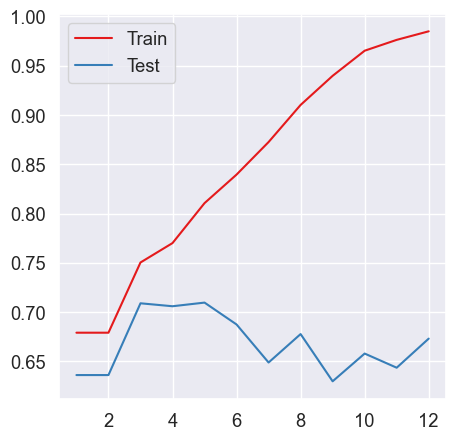

In [12]:
max_depth = [int(x) for x in np.linspace(1, 12, num = 12)]
train,test, param = [],[],[]

for i in max_depth:
        dt  = DecisionTreeClassifier(random_state=7, max_depth=i)
        dt.fit(X_train, y_train)

        #train
        train_score = roc_auc_score(y_train, dt.predict(X_train))
        train.append(train_score)

        #test
        test_score = roc_auc_score(y_test, dt.predict(X_test))
        test.append(test_score)

        param.append(i)

#buat visualisasi        
plt.figure(figsize=(5,5))
sns.lineplot(x=param, y=train, label='Train')
sns.lineplot(x=param, y=test, label='Test')

pd.DataFrame({
        'Param':param,
        'Train':train,
        'Test':test
})



Max depth paling optimal adalah 3

##### __MIN SAMPLE SPLIT__

,Param,Train,Test
0,10,0.75029,0.708869
1,11,0.75029,0.708869
2,12,0.75029,0.708869
3,13,0.75029,0.708869
4,14,0.75029,0.708869
5,15,0.75029,0.708869
6,16,0.75029,0.708869
7,17,0.75029,0.708869
8,18,0.75029,0.708869
9,19,0.75029,0.708869


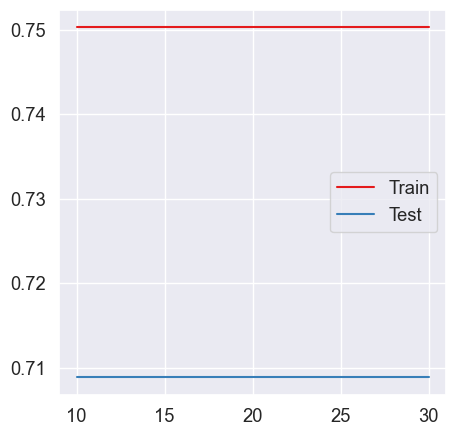

In [13]:
min_samples_split = [int(x) for x in np.linspace(10, 30, num = 20)]

train,test, param = [],[],[]

for i in min_samples_split:
        dt  = DecisionTreeClassifier(random_state=7, max_depth=3, min_samples_split=i)
        dt.fit(X_train, y_train)

        #train
        train_score = roc_auc_score(y_train, dt.predict(X_train))
        train.append(train_score)

        #test
        test_score = roc_auc_score(y_test, dt.predict(X_test))
        test.append(test_score)

        param.append(i)

#buat visualisasi        
plt.figure(figsize=(5,5))
sns.lineplot(x=param, y=train, label='Train')
sns.lineplot(x=param, y=test, label='Test')

pd.DataFrame({
        'Param':param,
        'Train':train,
        'Test':test
})


Min Sample Split yang optimal adalah 21

##### __MIN SAMPLES LEAF__

,Param,Train,Test
0,20,0.818076,0.738314
1,21,0.816918,0.734260
2,22,0.816918,0.734260
3,23,0.816918,0.734260
4,25,0.814021,0.721526


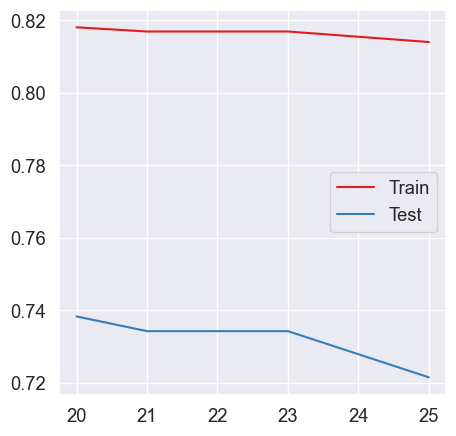

In [14]:
min_samples_leaf = [int(x) for x in np.linspace(20, 25, num = 5)]

train,test, param = [],[],[]

for i in min_samples_leaf:
        dt  = DecisionTreeClassifier(random_state=7, max_depth=6, min_samples_split=21, min_samples_leaf=i)
        dt.fit(X_train, y_train)

        #train
        train_score = roc_auc_score(y_train, dt.predict(X_train))
        train.append(train_score)

        #test
        test_score = roc_auc_score(y_test, dt.predict(X_test))
        test.append(test_score)

        param.append(i)

#buat visualisasi        
plt.figure(figsize=(5,5))
sns.lineplot(x=param, y=train, label='Train')
sns.lineplot(x=param, y=test, label='Test')

pd.DataFrame({
        'Param':param,
        'Train':train,
        'Test':test
})


Min Sample Leaf yang paling Optimal adalah 22

##### __CRITERION__

,Param,Train,Test
0,gini,0.816918,0.734260
1,entropy,0.812862,0.726932


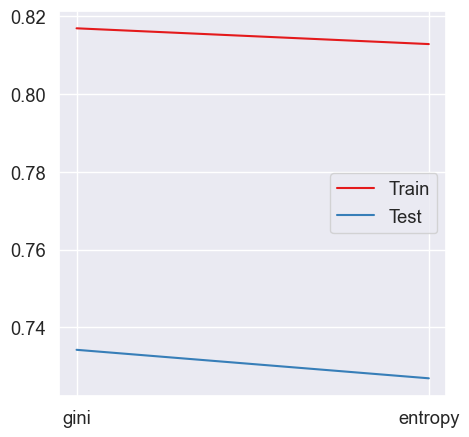

In [15]:
criterion = ['gini','entropy']

train,test, param = [],[],[]

for i in criterion:
        dt  = DecisionTreeClassifier(random_state=7, max_depth=6, min_samples_split=21, min_samples_leaf=22, criterion=i)
        dt.fit(X_train, y_train)

        #train
        train_score = roc_auc_score(y_train, dt.predict(X_train))
        train.append(train_score)

        #test
        test_score = roc_auc_score(y_test, dt.predict(X_test))
        test.append(test_score)

        param.append(i)

#buat visualisasi        
plt.figure(figsize=(5,5))
sns.lineplot(x=param, y=train, label='Train')
sns.lineplot(x=param, y=test, label='Test')

pd.DataFrame({
        'Param':param,
        'Train':train,
        'Test':test
})


Criterion Optimal adalah gini

,Param,Train,Test
0,best,0.816918,0.734260
1,random,0.788528,0.724439


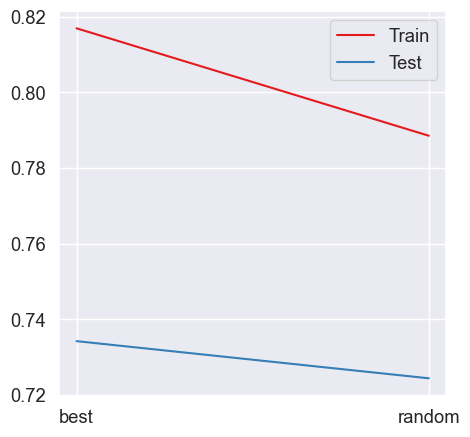

In [16]:
splitter = ['best','random']

train,test, param = [],[],[]

for i in splitter:
        dt  = DecisionTreeClassifier(random_state=7, max_depth=6, min_samples_split=21, min_samples_leaf=23, criterion='gini', splitter=i)
        dt.fit(X_train, y_train)

        #train
        train_score = roc_auc_score(y_train, dt.predict(X_train))
        train.append(train_score)

        #test
        test_score = roc_auc_score(y_test, dt.predict(X_test))
        test.append(test_score)

        param.append(i)

#buat visualisasi        
plt.figure(figsize=(5,5))
sns.lineplot(x=param, y=train, label='Train')
sns.lineplot(x=param, y=test, label='Test')

pd.DataFrame({
        'Param':param,
        'Train':train,
        'Test':test
})


Splitter optimal adalah random

##### __FINAL MODE DECISION TREEL__

In [17]:
dt  = DecisionTreeClassifier(random_state=7, max_depth=3, min_samples_split=20, min_samples_leaf=22, criterion='gini', splitter='random')
dt.fit(X_train, y_train)

eval_classification(dt)

model.append('Decision Tree')
accuracy.append(64)
precision.append(28)
recall.append(77)
f1.append(41)
auc.append(72)
status.append('Best Fit')

Accuracy (Test Set): 0.64
Precision (Test Set): 0.28
Recall (Test Set): 0.77
F1-Score (Test Set): 0.41

roc_auc (train-proba): 0.75
roc_auc (test-proba): 0.73

roc_auc (crossval train): 0.76
roc_auc (crossval test): 0.72


### __RANDOM FOREST__

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=7)
rf.fit(X_train, y_train)

eval_classification(rf)

Accuracy (Test Set): 0.84
Precision (Test Set): 0.50
Recall (Test Set): 0.49
F1-Score (Test Set): 0.50

roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.79

roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.8


#### __TUNING HYPERPARAMETER__

<b>Hyperparameter yang biasa di tuning pada Random Forest:</b> (<a href='https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html'>Dokumentasi Sklearn Random Forest</a>)
- n_estimators: jumlah subtree yang akan dibangun
- max_samples: Jumlah maksimal sampel pada masing-masing training subset (setelah proses bootstrap)

Sisa hyperparameter lainnya sama dengan Decision Tree, yaitu:
- criterion: cara menghitung impurity pada feature (gini, entropy). melihat feature mana yang menjadi root/node
- max_depth: maksimal kedalaman tree untuk mencegah overfitting
- min_sample_split: berapa jumlah sample yg dibutuhkan pada node untuk membuat leaf baru (agar tidak terlalu sedikit sehingga mengakibatkan overfit)
- min_sample_leaf: berapa jumlah sample yg dibutuhkan pada leaf agar leaf terbentuk (agar tidak terlalu sedikit sehingga mengakibatkan overfit)


In [19]:
n_estimators = [int(x) for x in np.linspace(1, 200, 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(2, 100, 50)]
min_samples_split = [int(x) for x in np.linspace(2, 20, 10)]
min_samples_leaf = [int(x) for x in np.linspace(2, 20, 10)]
hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

rf = RandomForestClassifier(random_state=7)

rs = RandomizedSearchCV(rf, hyperparameters, scoring='roc_auc', random_state=1, cv=5)

rs.fit(X_train, y_train)

eval_classification(rs)

model.append('Random Forest')
accuracy.append(83)
precision.append(47)
recall.append(63)
f1.append(54)
auc.append(82)
status.append('Over Fit')

Accuracy (Test Set): 0.82
Precision (Test Set): 0.46
Recall (Test Set): 0.61
F1-Score (Test Set): 0.52

roc_auc (train-proba): 0.98
roc_auc (test-proba): 0.80

roc_auc (crossval train): 0.94
roc_auc (crossval test): 0.82


In [20]:
rs.best_params_

{'n_estimators': 98,
 'min_samples_split': 18,
 'min_samples_leaf': 4,
 'max_depth': 90,
 'criterion': 'entropy'}

### __ADA BOOST__

In [21]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

eval_classification(ada)

model.append('Ada Boost')
accuracy.append(80)
precision.append(42)
recall.append(69)
f1.append(52)
auc.append(83)
status.append('Best Fit')

Accuracy (Test Set): 0.79
Precision (Test Set): 0.40
Recall (Test Set): 0.65
F1-Score (Test Set): 0.49

roc_auc (train-proba): 0.92
roc_auc (test-proba): 0.83

roc_auc (crossval train): 0.89
roc_auc (crossval test): 0.81


### __XGBOOST__

In [22]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train, y_train)

eval_classification(xg)

Accuracy (Test Set): 0.87
Precision (Test Set): 0.62
Recall (Test Set): 0.48
F1-Score (Test Set): 0.54

roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.80

roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.81


#### __TUNING HYPERPARAMETER__

<b>Hyperparameter yang umum di tuning pada XGBoost:</b> (<a href='https://xgboost.readthedocs.io/en/latest/parameter.html'>Dokumentasi XGBoost</a>)
- <b>Terkait arsitektur tree</b>:
    - max_depth: maksimal kedalaman tree untuk mencegah overfitting
    - min_child_weight: minimum weight (atau jumlah sample; jika total weightnya=1) yang dimiliki oleh node untuk membuat leaf baru (agar tidak terlalu sedikit sehingga mengakibatkan overfit)
    - gamma: minimum loss/error reduction yang diatur untuk membuat sebuah leaf baru
    - tree_method: bagaimana metode xgboost untuk membangun sebuah treenya. algoritma yang kita pelajari tree_method = exact. Referensi lain dapat dilihat <a href='https://xgboost.readthedocs.io/en/latest/treemethod.html'>disini</a>.

- <b>Terkait subsampling pada proses boosting</b>. Daripada menggunakan keseluruhan data train setiap iterasinya, kita dapat menggunakan sample pada setiap iterasinya/
    - subsample: berapa banyak baris sample yang digunakan untuk sampling di setiap stepnya. 1 untuk semua baris.
    - colsample_bytree: berapa banyak faeture yang digunakan. 1 untuk semua feature

- <b>Terkait control learning rate</b>:
    - eta: step size untuk update weight feature pada xgboost, range value: 0-1. semakin kecil eta, semakin detail perbaikannya, namun butuh lebih banyak iterasi dari boosting. 
        - di sklearn, nama hyperparameternya adalah learning_rate.
    
- <b>Regularization pada XGBoost</b>:
    - lambda: koefisien regularisasi pada L2 norm
    - alpha: koefisien regularisasi pada L1 norm

- <b>Terkait learning task XGBoost</b>:
    - objective: fungsi objective yang digunakan, seperti menghitung error pada regression
    - eval_metric: metrics evaluasi yang akan digunakan pada data validation (i.e. rmse, mae, auc)
    - seed: random state

- <b>Lainnya</b>:
    - scale_pos_weight: jika data imbalance, parameter ini digunakan untuk mengatur bobot dari masing-masing label.
    
- <b>Parameter lain yang untuk pengecekan dan debug model</b>:
    - verbose: untuk menampilkan detail log dari training model. 0: tidak menampilkan pesan apapun; 1: menampilkan jika ada warning saja; 2: menampilkan info (akan deprecated, contohnya); 3: debug: detail training dari model

In [23]:
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

xg = XGBClassifier(random_state=7)

rs = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=7, scoring='roc_auc')
rs.fit(X_train, y_train)

eval_classification(rs)

model.append('XG Boost')
accuracy.append(85)
precision.append(55)
recall.append(46)
f1.append(50)
auc.append(82)
status.append('Best Fit')

Accuracy (Test Set): 0.85
Precision (Test Set): 0.54
Recall (Test Set): 0.46
F1-Score (Test Set): 0.50

roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.81

roc_auc (crossval train): 0.89
roc_auc (crossval test): 0.82


In [26]:
hasil =pd.DataFrame({
        "Model":model,
        'Accuracy':accuracy,
        'Precision' : precision,
        'Recall' : recall,
        'F1 Score': f1,
        'Roc Auc': auc,
        'Status':status
})

hasil.sort_values(['Status','Roc Auc'],ascending=[True,False])

,Model,Accuracy,Precision,Recall,F1 Score,Roc Auc,Status
4,Ada Boost,80,42,69,52,83,Best Fit
5,XG Boost,85,55,46,50,82,Best Fit
0,Logistic Regression,74,35,69,46,81,Best Fit
2,Decision Tree,64,28,77,41,72,Best Fit
3,Random Forest,83,47,63,54,82,Over Fit
1,KNN,77,37,59,45,76,Over Fit
